Optimization terminated successfully.
         Current function value: 1843.206195
         Iterations: 130
         Function evaluations: 249


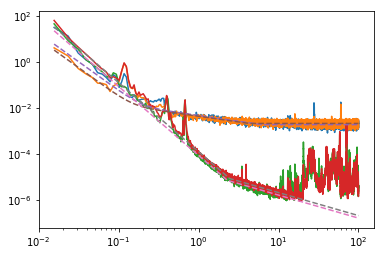

In [19]:
import dtt2hdf
import matplotlib.pyplot as plt
import numpy as np
items = dtt2hdf.read_diaggui('./data/BS_IP_noise_20200721.xml')
f = items.results.PSD['K1:VIS-BS_IP_BLEND_ACCL_IN1'].FHz
lvdtl = items.results.PSD['K1:VIS-BS_IP_BLEND_LVDTL_IN1'].PSD[0]
lvdtt = items.results.PSD['K1:VIS-BS_IP_BLEND_LVDTT_IN1'].PSD[0]
accl = items.results.PSD['K1:VIS-BS_IP_BLEND_ACCL_IN1'].PSD[0]
acct = items.results.PSD['K1:VIS-BS_IP_BLEND_ACCT_IN1'].PSD[0]
mask = f>=1e-2
f = f[mask]
lvdtl = lvdtl[mask]
lvdtt = lvdtt[mask]
accl = accl[mask]
acct = acct[mask]
plt.loglog(f,lvdtl)
plt.loglog(f,lvdtt)
plt.loglog(f,accl)
plt.loglog(f,acct)
from kontrol.model import *
from kontrol import quad_sum

def low_noise_model(f, seis_N0, lvdt_N0, lvdt_fc):
    noise = quad_sum(seis_N0/f**2.5, lvdt_noise(f, lvdt_N0, lvdt_fc, exp=[-0.5,0]))
    return(noise)

# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
low_noise_weight = np.ones_like(f)
for i in range(len(low_noise_weight)):
    if f[i]>0.05 and f[i]<0.5:
        low_noise_weight[i]=0
lvdtl_args = noise_fit(low_noise_model, f, lvdtl, weight = low_noise_weight,x0=[1e-4,1,8])
# lvdtt_args = noise_fit(low_noise_model, f, lvdtt, weight = low_noise_weight, x0=[1,1,8])
plt.loglog(f, low_noise_model(f, *lvdtl_args), '--')
plt.loglog(f, low_noise_model(f, *lvdtt_args), '--')

geo_noise_weight = np.ones_like(f)
# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
for i in range(len(geo_noise_weight)):
    if (f[i]>0.3 and f[i]<0.8) or f[i]>10:
        geo_noise_weight[i]=0

def high_noise_model(f, geo_N0, geo_fc):
    return(geophone_noise(f, geo_N0, geo_fc, exp=[-3,-1]))
# geol_args = noise_fit(high_noise_model, f, accl, weight = geo_noise_weight)
# geot_args = noise_fit(high_noise_model, f, acct, weight = geo_noise_weight)
plt.loglog(f, high_noise_model(f, *geol_args), '--')
plt.loglog(f, high_noise_model(f, *geot_args), '--')

# plt.loglog(f, low_noise_model(f, 1e-6, 1e-6, 1))
# data=np.loadtxt('./data/SR2_IP_noise_20200720a.txt')
# f, accltxt = data[:,0], data[:,4]
# plt.loglog(f,accltxt)
# len(accltxt)
# data
# plt.semilogx(np.angle(items.results.TF['K1:VIS-SR2_IP_BLEND_ACCL_IN1'].CSD[2]))

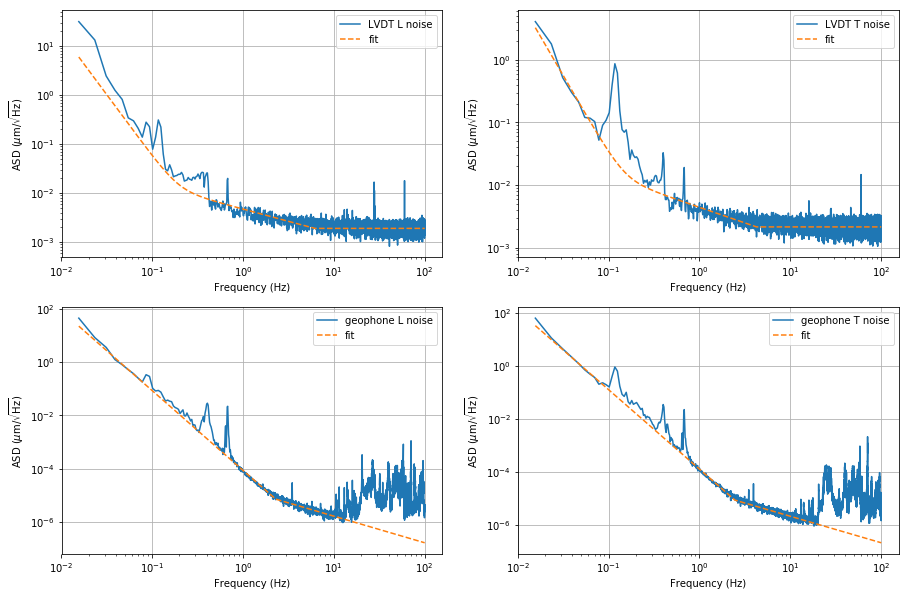

In [20]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.loglog(f,lvdtl, label='LVDT L noise')
plt.loglog(f, low_noise_model(f, *lvdtl_args), '--', label='fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(222)
plt.loglog(f,lvdtt, label = 'LVDT T noise')
plt.loglog(f, low_noise_model(f, *lvdtt_args), '--', label = 'fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(223)
plt.loglog(f,accl, label = 'geophone L noise')
plt.loglog(f, high_noise_model(f, *geol_args), '--', label = 'fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(224)
plt.loglog(f,acct, label = 'geophone T noise')
plt.loglog(f, high_noise_model(f, *geot_args), '--', label = 'fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

In [34]:
from kontrol.filter import (optimize_complementary_filter, 
    complementary_modified_sekiguchi, complementary_sekiguchi, complementary_lucia)
res = optimize_complementary_filter(
    complementary_modified_sekiguchi,
    spectra=[low_noise_model(f,*lvdtl_args),high_noise_model(f,*geol_args)],
    f=f,
#     bounds=[(0.01,10),(0.01,10),(0.01,10),(0.01,10),(0.5,1000),(0.01,10),(0.5,1000)],
    bounds = [(0,10),(0,10),(0,10),(0,10)]
#     x0=[0.32,0.32,0.32,0.32]
    )
# res.x/2/np.pi

Optimizing with scipy.optimize.differential_evolution
Done. Time taken: 22.04 s The 2-norm is 6.47 unit


In [66]:
res.x/2/np.pi

array([6.34813157e-02, 5.91889458e-02, 4.82634758e-02, 1.59154943e-03,
       6.04568845e+01, 6.40529907e-02, 5.85599424e+01])

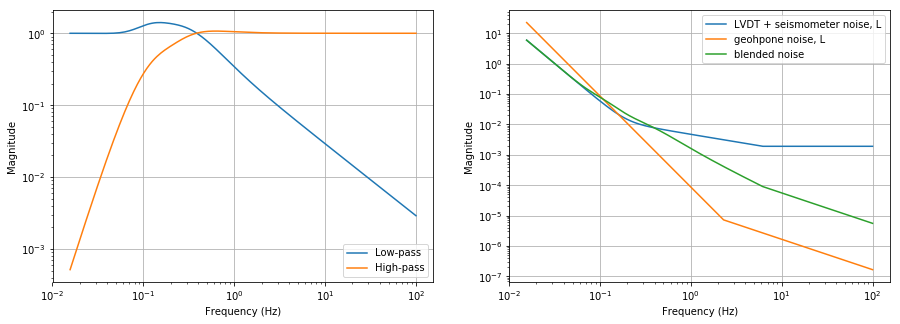

In [35]:
lpfl, hpfl = complementary_modified_sekiguchi(res.x)
# lpfl, hpfl = complementary_lucia(res.x)
# lpfl, hpfl = complementary_sekiguchi(res.x)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.loglog(f, abs(lpfl.horner(2*np.pi*1j*f)[0][0]), label = 'Low-pass')
plt.loglog(f, abs(hpfl.horner(2*np.pi*1j*f)[0][0]), label = 'High-pass')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(122)
plt.loglog(f, low_noise_model(f,*lvdtl_args), label = 'LVDT + seismometer noise, L')
plt.loglog(f, high_noise_model(f,*geol_args), label = 'geohpone noise, L')
plt.loglog(f, quad_sum(abs(lpfl.horner(2*np.pi*1j*f)[0][0])*low_noise_model(f,*lvdtl_args),
                       abs(hpfl.horner(2*np.pi*1j*f)[0][0])*high_noise_model(f,*geol_args)), 
           label = 'blended noise')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

In [36]:
lpfl, hpfl

(
    1.825 s^6 + 13.97 s^5 + 29.46 s^4 + 35.47 s^3 + 21.35 s^2 + 7.141 s + 1.024
 ---------------------------------------------------------------------------------
 s^7 + 7.023 s^6 + 21.14 s^5 + 35.35 s^4 + 35.47 s^3 + 21.35 s^2 + 7.141 s + 1.024,
 
                       s^7 + 5.199 s^6 + 7.169 s^5 + 5.89 s^4
 ---------------------------------------------------------------------------------
 s^7 + 7.023 s^6 + 21.14 s^5 + 35.35 s^4 + 35.47 s^3 + 21.35 s^2 + 7.141 s + 1.024)

In [41]:
res = optimize_complementary_filter(
    complementary_modified_sekiguchi,
    spectra=[low_noise_model(f,*lvdtt_args),high_noise_model(f,*geot_args)],
    f=f,
#     bounds=[(0.01,10),(0.01,10),(0.01,10),(0.01,10),(0.5,1000),(0.01,10),(0.5,1000)],
#     bounds=[(0,10),(0,10),(0,10),(0,10)]
    x0=[0.32,0.32,0.32,0.32]
    )

Optimizing with scipy.optimize.minimize
Done. Time taken: 22.49 s The 2-norm is 3.57 unit


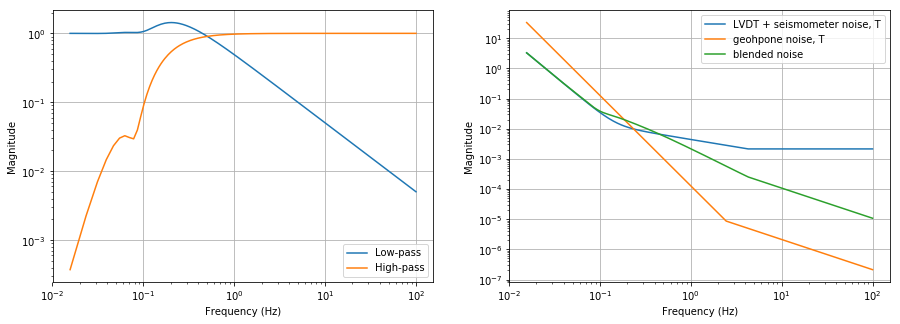

In [42]:
lpft, hpft = complementary_modified_sekiguchi(res.x)
# lpfl, hpfl = complementary_lucia(res.x)
# lpfl, hpfl = complementary_sekiguchi(res.x)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.loglog(f, abs(lpft.horner(2*np.pi*1j*f)[0][0]), label = 'Low-pass')
plt.loglog(f, abs(hpft.horner(2*np.pi*1j*f)[0][0]), label = 'High-pass')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(122)
plt.loglog(f, low_noise_model(f,*lvdtt_args), label = 'LVDT + seismometer noise, T')
plt.loglog(f, high_noise_model(f,*geot_args), label = 'geohpone noise, T')
plt.loglog(f, quad_sum(abs(lpft.horner(2*np.pi*1j*f)[0][0])*low_noise_model(f,*lvdtt_args),
                       abs(hpft.horner(2*np.pi*1j*f)[0][0])*high_noise_model(f,*geot_args)), 
           label = 'blended noise')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

In [43]:
lpft, hpft

(
   3.161 s^6 + 4.415 s^5 + 3.67 s^4 + 1.731 s^3 + 0.4896 s^2 + 0.07696 s + 0.005185
 -------------------------------------------------------------------------------------
 s^7 + 3.301 s^6 + 4.67 s^5 + 3.67 s^4 + 1.731 s^3 + 0.4896 s^2 + 0.07696 s + 0.005185,
 
                     s^7 + 0.1397 s^6 + 0.255 s^5 + 8.515e-08 s^4
 -------------------------------------------------------------------------------------
 s^7 + 3.301 s^6 + 4.67 s^5 + 3.67 s^4 + 1.731 s^3 + 0.4896 s^2 + 0.07696 s + 0.005185)